In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import network_util
import data_util
import re

In [46]:
def extract_drug_name(s):
    match = re.search(r'(\D+)', s)
    if match:
        return match.group(1).strip()
    return ""

In [47]:
reimbursed_medicines_path = os.path.join("data", "Refundowane.xlsx")
reimbursed_medicines_df = data_util.preprocess_reimbursed_dataset(reimbursed_medicines_path, "A1", "D,E,L,Q")
display(reimbursed_medicines_df)

,Package,GTIN,Refund_amount
0,30,5909990893423,13.26
1,30,5909990893386,6.64
2,30,5909990109920,3.30
3,60,5909990055715,9.44
4,30,5909991413590,6.33
...,...,...,...
4123,56,5909990681228,208.12
4124,1,5909990189212,15.36
4125,10,5909990189229,153.60
4126,100,5909990126729,22.29


In [48]:
# Leki refundowane z zerową kwotą refundacji
reimbursed_medicines_df[reimbursed_medicines_df["Refund_amount"] == 0]

,Package,GTIN,Refund_amount
20,30,5909990109319,0.0
21,30,5909990109210,0.0
865,30,5909990678648,0.0
868,30,5909990066667,0.0
1210,30,5909990014934,0.0
1990,50,5909991051112,0.0
2005,30,5909991013318,0.0
2009,30,5909990939718,0.0
2012,28,5909990682409,0.0
2015,28,5909991132927,0.0


In [49]:
reimbursed_medicines_df = reimbursed_medicines_df[reimbursed_medicines_df["Refund_amount"] != 0]

In [50]:
rpl_path = os.path.join("data", "RPL_20240102.csv")
rpl_df = data_util.preprocess_rpl_dataset(rpl_path, [8,13,14,15,16])
display(rpl_df)

,Postać farmaceutyczna,Podmiot odpowiedzialny,Substancja czynna,Nazwa wytwórcy,GTIN
0,Koncentrat do sporządzania roztworu do infuzji,Fresenius Kabi Polska Sp. z o.o.,Acidum zoledronicum 4 mg/5 ml,Fresenius Kabi Austria GmbH,5909991023652
0,Koncentrat do sporządzania roztworu do infuzji,Fresenius Kabi Polska Sp. z o.o.,Acidum zoledronicum 4 mg/5 ml,Fresenius Kabi Austria GmbH,5909991023669
0,Koncentrat do sporządzania roztworu do infuzji,Fresenius Kabi Polska Sp. z o.o.,Acidum zoledronicum 4 mg/5 ml,Fresenius Kabi Austria GmbH,5909991023676
1,Krem,Zakłady Farmaceutyczne POLPHARMA S.A.,Mometasoni furoas 1 mg/g,Glenmark Pharmaceuticals s.r.o.,5909991023683
1,Krem,Zakłady Farmaceutyczne POLPHARMA S.A.,Mometasoni furoas 1 mg/g,Glenmark Pharmaceuticals s.r.o.,5909991023690
...,...,...,...,...,...
21906,Tabletki dopochwowe,Delfarma Sp. z o.o.,Progesteronum 100 mg,NaN,5909991527662
21916,Tabletki,Medezin Sp. z o.o.,tert-Butylamini perindoprilum 8 mg,NaN,5909991527785
21919,Tabletki,Medezin Sp. z o.o.,Cilostazolum 100 mg,NaN,5909991527969
21919,Tabletki,Medezin Sp. z o.o.,Cilostazolum 100 mg,NaN,5909991527976


In [51]:
AVG = "mean"
SUM = "sum"
mode = AVG

In [52]:
merged_df = pd.merge(reimbursed_medicines_df, rpl_df, how="inner", left_on="GTIN", right_on="GTIN")
merged_df = merged_df.rename(
    columns={
        "Postać farmaceutyczna": "Form",
        "Podmiot odpowiedzialny": "Responsible_entity",
        "Substancja czynna": "Substance",
        "Nazwa wytwórcy": "Producer",
    }
)
merged_df["Responsible_entity"] = merged_df["Responsible_entity"].str.upper()
merged_df["Producer"] = merged_df["Producer"].str.upper()

# Calculate refund amount per unit of medicine and drop obsolete columns
merged_df["Producer"] = merged_df["Producer"].str.replace("\n", " ")
merged_df["Refund_per_unit"] = merged_df["Refund_amount"] / merged_df["Package"]
merged_df["Mean_refund"] = merged_df.groupby(["Form", "Responsible_entity", "Substance"])["Refund_per_unit"].transform("mean")
merged_df.drop(["Refund_amount", "Refund_per_unit", "Package"], axis=1, inplace=True)

# Drop duplicates - drops medicines which are being sold in different sizes
merged_df.drop_duplicates(["Form", "Responsible_entity", "Substance", "Producer", "Mean_refund"], inplace=True)

In [53]:
merged_groupby_entity = merged_df.groupby("Responsible_entity")
non_unique_counter = 0
unique_producers_per_entity = []
for value, group in merged_groupby_entity:
    count = len(group["Producer"].unique())
    unique_producers_per_entity.append((group, count))
    if count != 1:
        non_unique_counter += 1

In [54]:
print(
    f"Liczba unikalnych podmitów odpowiedzialnych: {len(merged_df['Responsible_entity'].unique())}"
)
print(
    f"Podmioty odpowiedzialne dla więcej niż jednego producenta: {non_unique_counter}"
)

Liczba unikalnych podmitów odpowiedzialnych: 183
Podmioty odpowiedzialne dla więcej niż jednego producenta: 101


In [55]:
unique_producers_per_entity = sorted(
    unique_producers_per_entity, key=lambda x: x[1], reverse=True
)

In [56]:
INDEX = 0

print(
    f"Podmiot odpowiedzialny: {unique_producers_per_entity[INDEX][0]['Responsible_entity'].unique()}, Stopień słupa: {unique_producers_per_entity[INDEX][1]}"
)
print(unique_producers_per_entity[INDEX][0]["Producer"].unique())

Podmiot odpowiedzialny: ['SANDOZ GMBH'], Stopień słupa: 54
['LEK PHARMACEUTICALS D.D. SALUTAS PHARMA GMBH'
 'LEK PHARMACEUTICALS D.D. LEK PHARMACEUTICALS D.D. LEK S.A. LEK S.A. ROWA PHARMACEUTICALS LTD. SALUTAS PHARMA GMBH'
 'NOVARTIS FARMA S.P.A. NOVARTIS FARMACÉUTICA, S.A. NOVARTIS PHARMA GMBH'
 'NOVARTIS FARMA S.P.A. NOVARTIS FARMACÉUTICA, S.A. NOVARTIS PHARMA GMBH SALUTAS PHARMA'
 'SANDOZ GMBH' 'SALUTAS PHARMA GMBH SANDOZ GMBH'
 'LEK PHARMACEUTICALS D.D. RONTIS HELLAS MEDICAL AND PHARMACEUTICAL PRODUCTS S.A.'
 'LEK PHARMACEUTICALS D.D. LEK S.A. S.C. SANDOZ S.R.L.' 'LEK S.A.'
 'LEK PHARMACEUTICALS D.D. LEK PHARMACEUTICALS D.D. LEK S.A. LEK S.A. SALUTAS PHARMA GMBH'
 'LEK PHARMACEUTICALS D.D. SALUTAS PHARMA GMBH SANDOZ S.R.L.'
 'LEK PHARMACEUTICALS D.D. SALUTAS PHARMA GMBH S.C.SANDOZ S.R.L.'
 'LEK PHARMACEUTICALS D.D. SANDOZ GMBH S.C. SANDOZ S.R.L.'
 'LEK PHARMACEUTICALS D.D. SANDOZ GMBH SANDOZ S.R.L.'
 'AEROPHARM GMBH LEK PHARMACEUTICALS D.D. SALUTAS PHARMA GMBH'
 'AEROPHARM GMBH LE

In [57]:
# Groupby 
merged_df_org = merged_df.copy()
merged_df['Substance'] = merged_df['Substance'].apply(extract_drug_name)

temp_df = merged_df.copy()
temp_df['Agg_refund'] = temp_df.groupby(["Form", "Responsible_entity", "Substance"])["Mean_refund"].transform(SUM)

temp_df.drop(['Mean_refund'],axis = 1, inplace=True)
temp_df.drop_duplicates(["Form", "Responsible_entity", "Substance", "Producer", "Agg_refund"], inplace=True)
merged_df_sum = temp_df.copy()

temp_df = merged_df.copy()
temp_df['Agg_refund'] = temp_df.groupby(["Form", "Responsible_entity", "Substance"])["Mean_refund"].transform(AVG)

temp_df.drop(['Mean_refund'],axis = 1, inplace=True)
temp_df.drop_duplicates(["Form", "Responsible_entity", "Substance", "Producer", "Agg_refund"], inplace=True)
merged_df_avg = temp_df.copy()

# Change name in original dataframe so it matches the schema
merged_df_org = merged_df_org.rename(
        columns={
            "Mean_refund": "Agg_refund",
        }
    )

In [58]:
graph = network_util.create_bipartite_graph(merged_df_org["Substance"], merged_df_org['Responsible_entity'], merged_df_org["Agg_refund"])
pos_g = network_util.create_bipartite_layout(merged_df_org["Substance"], merged_df_org['Responsible_entity'])

g_sum = network_util.create_bipartite_graph(merged_df_sum["Substance"], merged_df_sum['Responsible_entity'], merged_df_sum["Agg_refund"])
pos_sum = network_util.create_bipartite_layout(merged_df_sum["Substance"], merged_df_sum['Responsible_entity'])

g_avg = network_util.create_bipartite_graph(merged_df_avg["Substance"], merged_df_avg['Responsible_entity'], merged_df_avg["Agg_refund"])
pos_avg = network_util.create_bipartite_layout(merged_df_avg["Substance"], merged_df_avg['Responsible_entity'])

g_sum_producer = network_util.create_bipartite_graph(merged_df_sum["Substance"], merged_df_sum['Producer'], merged_df_sum["Agg_refund"])
pos_sum_producer = network_util.create_bipartite_layout(merged_df_sum["Substance"], merged_df_sum['Producer'])

g_avg_producer  = network_util.create_bipartite_graph(merged_df_avg["Substance"], merged_df_avg['Producer'], merged_df_avg["Agg_refund"])
pos_avg_producer  = network_util.create_bipartite_layout(merged_df_avg["Substance"], merged_df_avg['Producer'])

In [59]:
# plt.figure(figsize=(12, 20))
# nx.draw(graph, pos=pos_g, with_labels=True, font_weight='bold', node_color='skyblue', font_size=4)
# plt.show()

In [60]:
# plt.figure(figsize=(12, 20))
# nx.draw(g_sum, pos=pos_sum, with_labels=True, font_weight='bold', node_color='skyblue', font_size=4)
# plt.show()

In [61]:
# plt.figure(figsize=(12, 20))
# nx.draw(g_avg, pos=pos_avg, with_labels=True, font_weight='bold', node_color='skyblue', font_size=4)
# plt.show()

In [69]:
entity_nodes_g_avg_producer = {n for n, d in g_avg_producer.nodes(data=True) if d['bipartite'] == 1}
substance_nodes_g_avg_producer = {n for n, d in g_avg_producer.nodes(data=True) if d['bipartite'] == 0}

entity_share = network_util.get_entity_share(g_avg_producer, substance_nodes_g_avg_producer)
print(entity_share)
print("--------------------------------------")

favored_producers, n_monopolists = network_util.get_favored_producer(entity_share)
print(f"Monopolists: {n_monopolists}")
for elem in sorted(list(favored_producers.items()), key=lambda x : x[1], reverse=True)[:5]:
    print(f"Podmiot odpowiedzialny: {elem[0]}, Liczba wygranych: {elem[1]}")

{'Quinaprilum': ([['BAUSCH HEALTH POLAND SP. Z O.O. ICN POLFA RZESZÓW', 1.0]], 0.212), 'Travoprostum + Timololum': ([['BALKANPHARMA-RAZGRAD AD JADRAN-GALENSKI LABORATORIJ D.D. PHARMATHEN S.A.', 1.0]], 28.97), 'Insulinum glarginum': ([['SANOFI-AVENTIS DEUTSCHLAND GMBH SANOFI-AVENTIS S.P.A.', 0.247], ['SANOFI-AVENTIS DEUTSCHLAND GMBH', 0.753]], 109.85249999999999), 'Pyridostigmini bromidum': ([['ICN POLFA RZESZÓW S.A. LABIANA PHARMACEUTICALS, S.L.', 1.0]], 0.6540666666666667), 'Cenobamate': ([['AZIENDE CHIMICHE RIUNITE ANGELINI FRANCESCO ACRAF SPA SWISS CAPS GMBH', 1.0]], 17.5725), 'Ergotamini tartras': ([['FARMACEUTYCZNA SPÓŁDZIELNIA PRACY FILOFARM', 1.0]], 0.156), 'Fentanylu cytrynian -': ([['ARDENA PAMPLONA S.L. BLUEPHARMA INDUSTRIA FARMACEUTICA S.A.', 1.0]], 15.229642857142858), 'Cefaclorum': ([['ACS DOBFAR S.P.A TEVA OPERATIONS POLSKA SP. Z O.O.', 1.0]], 0.9919523809523808), 'Anastrozolum': ([['BLUEFISH PHARMACEUTICALS AB GENEPHARM S.A.', 0.126], ['IVAX PHARMACEUTICALS, S.R.O. MERCK

In [70]:
entity_nodes_g_avg = {n for n, d in g_avg.nodes(data=True) if d['bipartite'] == 1}
substance_nodes_g_avg = {n for n, d in g_avg.nodes(data=True) if d['bipartite'] == 0}

entity_share = network_util.get_entity_share(g_avg, substance_nodes_g_avg)
print(entity_share)
print("--------------------------------------")

favored_producers, n_monopolists = network_util.get_favored_producer(entity_share)
print(f"Monopolists: {n_monopolists}")
for elem in sorted(list(favored_producers.items()), key=lambda x : x[1], reverse=True)[:5]:
    print(f"Podmiot odpowiedzialny: {elem[0]}, Liczba wygranych: {elem[1]}")

{'Quinaprilum': ([['BAUSCH HEALTH IRELAND LTD.', 1.0]], 0.212), 'Travoprostum + Timololum': ([['MEDICAL VALLEY INVEST AB', 1.0]], 28.97), 'Insulinum glarginum': ([['SANOFI-AVENTIS DEUTSCHLAND GMBH', 0.247], ['SANOFI WINTHROP INDUSTRIE', 0.753]], 109.85249999999999), 'Pyridostigmini bromidum': ([['MYLAN HEALTHCARE SP. Z O.O.', 1.0]], 0.6540666666666667), 'Cenobamate': ([['ANGELINI PHARMA S.P.A.', 1.0]], 17.5725), 'Ergotamini tartras': ([['FARMACEUTYCZNA SPÓŁDZIELNIA PRACY FILOFARM', 1.0]], 0.156), 'Fentanylu cytrynian -': ([['AUROVITAS PHARMA POLSKA SP. Z O.O.', 1.0]], 15.229642857142858), 'Cefaclorum': ([['TEVA PHARMACEUTICALS POLSKA SP. Z O.O.', 1.0]], 0.9919523809523808), 'Anastrozolum': ([['BLUEFISH PHARMACEUTICALS AB', 0.126], ['TEVA PHARMACEUTICALS POLSKA SP. Z O.O.', 0.127], ['EUGIA PHARMA (MALTA) LTD.', 0.118], ['AUROVITAS PHARMA POLSKA SP. Z O.O.', 0.127], ['LABORATOIRES JUVISE PHARMACEUTICALS', 0.127], ['VIPHARM S.A.', 0.127], ['EGIS PHARMACEUTICALS PLC', 0.127], ['DELFARMA SP

In [81]:
entity_nodes_g_sum_producer = {n for n, d in g_sum_producer.nodes(data=True) if d['bipartite'] == 1}
substance_nodes_g_sum_producer = {n for n, d in g_sum_producer.nodes(data=True) if d['bipartite'] == 0}

print(network_util.get_entity_share(g_sum_producer, substance_nodes_g_sum_producer))

{'Quinaprilum': ([['BAUSCH HEALTH POLAND SP. Z O.O. ICN POLFA RZESZÓW', 1.0]], 0.212), 'Travoprostum + Timololum': ([['BALKANPHARMA-RAZGRAD AD JADRAN-GALENSKI LABORATORIJ D.D. PHARMATHEN S.A.', 1.0]], 28.97), 'Insulinum glarginum': ([['SANOFI-AVENTIS DEUTSCHLAND GMBH SANOFI-AVENTIS S.P.A.', 0.247], ['SANOFI-AVENTIS DEUTSCHLAND GMBH', 0.753]], 219.70499999999998), 'Pyridostigmini bromidum': ([['ICN POLFA RZESZÓW S.A. LABIANA PHARMACEUTICALS, S.L.', 1.0]], 0.6540666666666667), 'Cenobamate': ([['AZIENDE CHIMICHE RIUNITE ANGELINI FRANCESCO ACRAF SPA SWISS CAPS GMBH', 1.0]], 17.5725), 'Ergotamini tartras': ([['FARMACEUTYCZNA SPÓŁDZIELNIA PRACY FILOFARM', 1.0]], 0.156), 'Fentanylu cytrynian -': ([['ARDENA PAMPLONA S.L. BLUEPHARMA INDUSTRIA FARMACEUTICA S.A.', 1.0]], 15.229642857142858), 'Cefaclorum': ([['ACS DOBFAR S.P.A TEVA OPERATIONS POLSKA SP. Z O.O.', 1.0]], 2.9758571428571425), 'Anastrozolum': ([['BLUEFISH PHARMACEUTICALS AB GENEPHARM S.A.', 0.126], ['IVAX PHARMACEUTICALS, S.R.O. MERCK

In [82]:
entity_substances = network_util.get_substances(g_avg, entity_nodes_g_avg)
print(len(entity_substances))

183


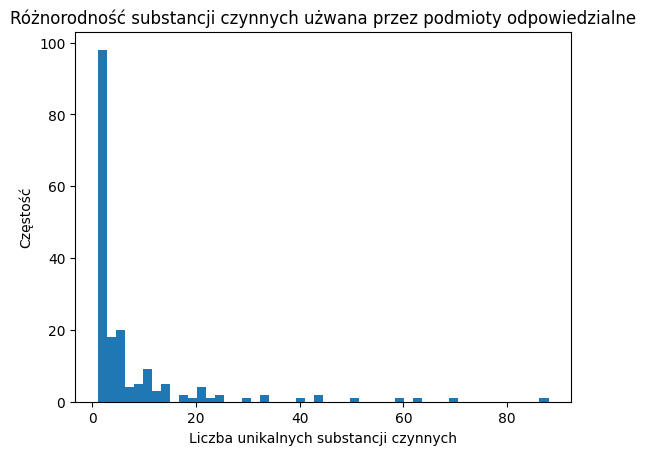

In [83]:
n_substances = [len(substances) for substances in entity_substances.values()]

plt.hist(n_substances, bins=50)

plt.xlabel("Liczba unikalnych substancji czynnych")
plt.ylabel("Częstość")
plt.title("Różnorodność substancji czynnych użwana przez podmioty odpowiedzialne")
plt.show()


In [86]:
for key in entity_substances.keys():
    if len(entity_substances[key]) > 40:
        print(f"{key}:")
        print(f"count:{len(entity_substances[key])}")
        print(f"substances:{entity_substances[key]}")

SANDOZ GMBH:
count:60
substances:['Allopurinolum', 'Amlodipinum', 'Amlodipini besilas', 'Amoxicillinum', 'Aprepitantum', 'Aripiprazolum', 'Atorvastatinum calcicum trihydricum', 'Azytromycyna dwuwodna', 'Azithromycinum', 'Benzathini phenoxymethylpenicillinum', 'Budesonidum', 'Candesartanum cilexetili', 'Candesartanum cilexetilum', 'Hydrochlorothiazidum', 'Cefuroximum', 'Cefuroximum natricum', 'Cefuroximum axetilum', 'Clindamycini hydrochloridum', 'Clindamycini phosphas', 'Clopidogrelum hydrosulfas', 'Desloratadinum', 'Diclofenacum natricum', 'Ezetimibum', 'Filgrastimum', 'Salmeterolu ksynafonian', 'Formoteroli fumaras', 'Gliclazidum', 'Glimepiridum', 'Ketoprofenum', 'Leflunomidum', 'Leuprorelini acetas', 'Levodopum', 'Lisinoprilum dihydricum', 'Loratadinum', 'Metformini hydrochloridum', 'Mometasoni furoas', 'Montelukastum natricum', 'Mycophenolas mofetil', 'Acidum valproicum + Natrii valproas', 'Nebivololi hydrochloridum', 'Ondansetroni hydrochloridum dihydricum', 'Ondansetronum', 'Pant